In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q "/content/drive/My Drive/424 group project/dataset.zip" -d "/content/dataset"

In [3]:
#!pip install pytorch-minimize
#!pip install torchmetrics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch as pt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torchmin import minimize


import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torch.nn.utils import clip_grad_norm_
import time

## Data Processing


In [4]:
from torch.utils.data import DataLoader, random_split
import torchvision

torch.manual_seed(42)

#batch_size = 780

batch_size = 256

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.6501, 0.5935, 0.5400], std=[0.2304, 0.2381, 0.2500])
])

train_directory = '/content/dataset/train'
test_directory = '/content/dataset/test'


# Create dataset
train_dataset = torchvision.datasets.ImageFolder(train_directory, transform=transform)
val_dataset = torchvision.datasets.ImageFolder(test_directory, transform=transform)

train_size = int(0.9 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = random_split(train_dataset, [train_size, test_size])


# Create data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



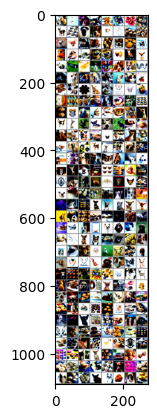

In [5]:
# dataloader check

import matplotlib.pyplot as plt
import torchvision
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

classes = ('chihuahua', 'muffin')

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Model Architecture


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ChihuahuaMuffinCNN(nn.Module):
    def __init__(self):
        super(ChihuahuaMuffinCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)  # The image size is reduced to 4x4 after all the pooling
        self.fc2 = nn.Linear(128, 2)  # Two output classes: chihuahua and muffin

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 64 * 4 * 4)  # Flatten the output for the dense layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = ChihuahuaMuffinCNN().to(device)

print(model)


muffin chihuahua muffin chihuahua muffin muffin muffin muffin chihuahua muffin chihuahua chihuahua chihuahua chihuahua muffin muffin chihuahua chihuahua chihuahua muffin muffin chihuahua muffin chihuahua chihuahua chihuahua muffin muffin muffin muffin chihuahua chihuahua muffin chihuahua muffin chihuahua chihuahua muffin chihuahua chihuahua chihuahua chihuahua muffin muffin chihuahua chihuahua muffin chihuahua muffin muffin chihuahua chihuahua muffin chihuahua chihuahua muffin chihuahua muffin muffin muffin chihuahua muffin chihuahua muffin muffin muffin chihuahua muffin muffin muffin muffin chihuahua chihuahua chihuahua chihuahua chihuahua chihuahua chihuahua muffin muffin chihuahua muffin muffin muffin chihuahua muffin chihuahua muffin muffin chihuahua chihuahua chihuahua chihuahua muffin chihuahua muffin muffin muffin chihuahua muffin chihuahua chihuahua chihuahua chihuahua chihuahua chihuahua muffin chihuahua chihuahua muffin chihuahua muffin chihuahua chihuahua chihuahua chihuahua

In [7]:
def reinitialize_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()


reinitialize_weights(model)

In [8]:
model.conv2.weight

Parameter containing:
tensor([[[[ 0.0543, -0.0479,  0.0382],
          [-0.0298,  0.0425, -0.0478],
          [ 0.0713, -0.0593, -0.0255]],

         [[ 0.0829,  0.0089, -0.0418],
          [ 0.0717, -0.0368,  0.0571],
          [ 0.0035, -0.0603,  0.0326]],

         [[ 0.0153,  0.0617, -0.0152],
          [ 0.0465, -0.0206, -0.0555],
          [-0.0276, -0.0135, -0.0644]],

         ...,

         [[-0.0591,  0.0156,  0.0165],
          [-0.0580,  0.0228, -0.0292],
          [ 0.0537,  0.0618,  0.0832]],

         [[ 0.0150, -0.0728,  0.0413],
          [-0.0030, -0.0827, -0.0516],
          [ 0.0601,  0.0403,  0.0627]],

         [[ 0.0757,  0.0749, -0.0487],
          [ 0.0224,  0.0800, -0.0247],
          [ 0.0540, -0.0409,  0.0533]]],


        [[[ 0.0430, -0.0486,  0.0799],
          [ 0.0360, -0.0673, -0.0713],
          [ 0.0466, -0.0506, -0.0720]],

         [[ 0.0552, -0.0547,  0.0429],
          [ 0.0101,  0.0033,  0.0453],
          [-0.0812,  0.0280,  0.0005]],

         

## Model Assessment

In [9]:
def evaluate_accuracy(model, data_loader, device):
    """
    Evaluate the accuracy of the model on a given dataset.

    Parameters:
    - model: The neural network model.
    - data_loader: DataLoader for the dataset to evaluate.
    - device: The device to run the model on ('cuda' or 'cpu').

    Returns:
    - accuracy: The accuracy of the model on the dataset.
    """
    #model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # During evaluation, we don't need gradient computation
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

# Stochastic LGBFS

In [ ]:
# Training with LBFGS

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS(model.parameters(), lr=0.01)  # Initialize the LBFGS optimizer

num_epochs = 30  # Number of epochs to train for


def train():
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_loss = 0.0

        # Randomly shuffle the data at the beginning of each epoch
        #train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Define the closure function that will recompute the loss for LBFGS
            def closure():
                optimizer.zero_grad()  # Clear the gradients of all optimized variables
                outputs = model(images)  # Forward pass: compute the predicted outputs by passing inputs to the model
                loss = criterion(outputs, labels)  # Calculate the loss
                loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
                return loss

            optimizer.step(closure)  # Perform a single optimization step
            loss = closure()  # Perform a single optimization step
            total_loss += loss.item()
            # Optional: Invalidate the closure to free up memory
            del closure

        average_loss = total_loss/len(train_loader)
        # Evaluate model accuracy on the validation set after each epoch
        val_accuracy = evaluate_accuracy(model, val_loader, device)
        path = f'/content/drive/MyDrive/424 group project/gd_newstochasticlfbgs_{epoch}.pth'
        torch.save(model.state_dict(), path)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
train()


Epoch 1/30, Loss: 1121.1166, Validation Accuracy: 0.6233
Epoch 2/30, Loss: 680.5982, Validation Accuracy: 0.6410
Epoch 3/30, Loss: 347.4817, Validation Accuracy: 0.6470
Epoch 4/30, Loss: 204.0460, Validation Accuracy: 0.6647
Epoch 5/30, Loss: 157.0470, Validation Accuracy: 0.6537
Epoch 6/30, Loss: 118.1334, Validation Accuracy: 0.6520
Epoch 7/30, Loss: 86.9315, Validation Accuracy: 0.6858
Epoch 8/30, Loss: 70.7760, Validation Accuracy: 0.7044
Epoch 9/30, Loss: 64.3057, Validation Accuracy: 0.7154
Epoch 10/30, Loss: 44.6027, Validation Accuracy: 0.7221
Epoch 11/30, Loss: 39.7541, Validation Accuracy: 0.7230
Epoch 12/30, Loss: 33.2463, Validation Accuracy: 0.7314
Epoch 13/30, Loss: 28.6087, Validation Accuracy: 0.7584
Epoch 14/30, Loss: 23.1401, Validation Accuracy: 0.7534
Epoch 15/30, Loss: 1930.7748, Validation Accuracy: 0.6115
Epoch 16/30, Loss: 372.9735, Validation Accuracy: 0.6588
Epoch 17/30, Loss: 191.5651, Validation Accuracy: 0.6436
Epoch 18/30, Loss: 712.5282, Validation Accura

KeyboardInterrupt: 

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/424 group project/newstochasticlfbgs_8.pth'))
test_accuracy = evaluate_accuracy(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.8882


# LGBFS Improved for timing

In [ ]:
# Training with LBFGS

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS(model.parameters(), lr=0.01)  # Initialize the LBFGS optimizer

num_epochs = 15  # Number of epochs to train for


def train():
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_loss = 0.0

        # Randomly shuffle the data at the beginning of each epoch
        # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Define the closure function that will recompute the loss for LBFGS
            def closure():
                optimizer.zero_grad()  # Clear the gradients of all optimized variables
                outputs = model(images)  # Forward pass: compute the predicted outputs by passing inputs to the model
                loss = criterion(outputs, labels)  # Calculate the loss
                loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
                return loss

            loss = optimizer.step(closure)  # Perform a single optimization step
            total_loss += loss.item()

            # Optional: Invalidate the closure to free up memory
            del closure

        average_loss = total_loss/len(train_loader)
        # Evaluate model accuracy on the validation set after each epoch
        val_accuracy = evaluate_accuracy(model, val_loader, device)
        path = f'/content/drive/MyDrive/424 group project/stochasticlfbgs_{epoch}.pth'
        torch.save(model.state_dict(), path)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
train()


Epoch 1/10, Loss: 0.5716, Validation Accuracy: 0.7939
Epoch 2/10, Loss: 0.4423, Validation Accuracy: 0.8277
Epoch 3/10, Loss: 0.3834, Validation Accuracy: 0.8556
Epoch 4/10, Loss: 0.3488, Validation Accuracy: 0.8606
Epoch 5/10, Loss: 0.2964, Validation Accuracy: 0.8657
Epoch 6/10, Loss: 0.2692, Validation Accuracy: 0.8649
Epoch 7/10, Loss: 0.4491, Validation Accuracy: 0.8767
Epoch 8/10, Loss: 367044.9062, Validation Accuracy: 0.5405
Epoch 9/10, Loss: nan, Validation Accuracy: 0.5405
Epoch 10/10, Loss: nan, Validation Accuracy: 0.5405


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/424 group project/stochasticlfbgs_6.pth'))

<All keys matched successfully>

In [ ]:
test_accuracy = evaluate_accuracy(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9051


# TIMING LBFGS

In [10]:
# Training with LBFGS

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS(model.parameters(), lr=0.01)  # Initialize the LBFGS optimizer

num_epochs = 10  # Number of epochs to train for


def train():
    start_time = time.time()
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()  # Set model to training mode
        total_loss = 0.0

        # Randomly shuffle the data at the beginning of each epoch
        # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Define the closure function that will recompute the loss for LBFGS
            def closure():
                optimizer.zero_grad()  # Clear the gradients of all optimized variables
                outputs = model(images)  # Forward pass: compute the predicted outputs by passing inputs to the model
                loss = criterion(outputs, labels)  # Calculate the loss
                loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
                return loss

            loss = optimizer.step(closure)  # Perform a single optimization step
            total_loss += loss.item()

            # Optional: Invalidate the closure to free up memory
            del closure


        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        average_loss = total_loss/len(train_loader)
        # Evaluate model accuracy on the validation set after each epoch
        val_accuracy = evaluate_accuracy(model, val_loader, device)
        path = f'/content/drive/MyDrive/424 group project/stochasticlfbgsHaris_{epoch}.pth'
        torch.save(model.state_dict(), path)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, DURATION: {epoch_duration:.2f} seconds')

    end_time = time.time()
    total_duration = end_time - start_time
    print(f'Total Training Duration: {total_duration:.2f} seconds')
train()


Epoch 1/10, Loss: 21.3818, Validation Accuracy: 0.5329, DURATION: 51.57 seconds
Epoch 2/10, Loss: 0.9218, Validation Accuracy: 0.6765, DURATION: 44.79 seconds
Epoch 3/10, Loss: nan, Validation Accuracy: 0.5405, DURATION: 45.06 seconds
Epoch 4/10, Loss: nan, Validation Accuracy: 0.5405, DURATION: 44.24 seconds
Epoch 5/10, Loss: nan, Validation Accuracy: 0.5405, DURATION: 43.37 seconds
Epoch 6/10, Loss: nan, Validation Accuracy: 0.5405, DURATION: 44.68 seconds
Epoch 7/10, Loss: nan, Validation Accuracy: 0.5405, DURATION: 43.96 seconds
Epoch 8/10, Loss: nan, Validation Accuracy: 0.5405, DURATION: 43.56 seconds
Epoch 9/10, Loss: nan, Validation Accuracy: 0.5405, DURATION: 43.02 seconds
Epoch 10/10, Loss: nan, Validation Accuracy: 0.5405, DURATION: 44.87 seconds
Total Training Duration: 565.41 seconds
